Code adapted and modified from https://github.com/blei-lab/variational-smc.

In [85]:
save_figures = true

true

In [26]:
using Random, LinearAlgebra, Distributions, Plots, LaTeXStrings

# AutoGrad is used due to being able to "ignore" the gradients of specific functions
using AutoGrad, ForwardDiff

# Adam optimizer
using HTTP: request
"https://gist.githubusercontent.com/vankesteren/96207abcd16ecd01a2491bcbec12c73f/raw/1b59af6962a1107db5873eba59054acc3f9a8aac/Adamopt.jl" |>
    url -> request("GET", url) |> 
    res -> String(res.body) |> 
    str -> include_string(Main, str)
using .Adamopt

In [49]:
# "Class" for encapsulating items needed for SMC
mutable struct SMC
    dimX::Integer  # Dimension of latent variables
    dimY::Integer  # Dimension of observations
    T::Integer     # Length of sequence
    N::Integer     # Number of particles
    
    sim_prop       # Function for sampling from proposal
    log_weights    # Function for computing weights
end

VSMC = "VSMC"
uVSMC = "uVSMC"
GS_VSMC = "GS-VSMC"
IGR_VSMC = "IGR-VSMC"

VSMC_col = :blue
uVSMC_col = :purple
GS_VSMC_col = :red
IGR_VSMC_col = :green

:green

In [7]:
function rho(i,∇obj,prev_s;δ=1e-16,t=0.1,η=0.1)
    s = t*(∇obj)^2+(1-t)*prev_s
    ρ = η*i^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s, ρ
end

function gradient_descent(obj_f, grad_f, opt_params; iters=100, step="rho")
    dim_params = length(opt_params)
    params = zeros(iters,dim_params)
    objs = zeros(iters)
    
    params[1,:] .= opt_params
    objs[1] = obj_f(opt_params)
    
    if step == "rho"
        ss = ones(iters,dim_params)
    else
        loss_f = params -> -obj_f(params)
        Adam_grad_f = params -> -grad_f(params)
        Adam_opt = Adam(opt_params, loss_f, Adam_grad_f)
        Adam_opt.a = 0.01
    end
    
    for i in 1:iters-1
        ∇obj = grad_f(params[i,:])
        if step == "rho"
            for j in 1:dim_params
                s, ρ = rho(i,∇obj[j],ss[i])
                ss[i+1,j] = s
                params[i+1,j] = params[i,j] + ρ*∇obj[j]
            end
            objs[i+1] = obj_f(params[i+1,:])
        else
            step!(Adam_opt)
            params[i+1,:] = Adam_opt.theta
            objs[i+1] = -Adam_opt.loss(params[i+1,:])
        end
    end
    return params, objs
end

gradient_descent (generic function with 1 method)

In [4]:
function log_marginal_likelihood(model_params, T, y_true, dimX)
    μ0, Σ0, A, Q, C, R = model_params
    
    # Compute via Kalman filter
    log_likelihood = 0
    
    x_filt = zeros(dimX)
    P_filt = zeros(dimX,dimX)
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update
        yt = y_true[t,:] .- C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred .+ K*yt
        P_filt = P_pred - K*C*P_pred
        
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + log(2*π))
    end
    return log_likelihood
end

function log_normal(x,μ,Σ)
    dim = size(x)[2]
    log_norm = -0.5*dim*log(2*π) - 0.5*logdet(Σ)
    if size(x) == size(μ)
        diff = x - μ
    else
        diff = x .- μ'
    end
    prec = inv(Σ) # AutoGrad doesn't support backslash
    return log_norm .- 0.5*diag(diff*prec*diff') # Original code does sum here but that seems incorrect
end

function log_target(t, X, X_anc, y, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    log_trans = log_normal(X,(A*X_anc')',Q)
    #if t > 1
    #    log_trans = log_normal(X,(A*X_anc')',Q)
    #else
    #    log_trans = log_normal(X,μ0,Σ0)
    #end
    log_obs = log_normal((C*X')',y[t],R)
    return log_trans + log_obs
end

log_target (generic function with 1 method)

In [120]:
function categorical_resample(W)
    dist = Categorical(W[:,1])
    return rand(dist,N)
end
@zerograd categorical_resample(W)

function gumbelsoftmax_resample(W,X,τ)
    N = size(W)[1]
    g = -log.(-log.(rand(N,N)))
    mix_prop = exp.((log.(W') .+ g) ./ τ)
    mix_prop = mix_prop ./ sum(mix_prop, dims=2)
    return mix_prop * X
end

function cost(p; τ=0.05, W, n=100)
    N = size(W)[1]
    μ = p[1:N-1]
    σ = exp.(p[N:(2*(N-1))])
    δ = 1
    z = (μ' .+ σ' .* randn(n,N-1)) ./ τ
    maxz = maximum(z, dims=2)
    z = exp.(z .- maxz)
    z = z ./ (sum(z, dims=2) .+ δ .* exp.(-maxz))
    z = [z (1 .- sum(z, dims=2))]
    c = sum((mean(z, dims=1) .- W').^2)
    return c
end

function invertgaussian_resample(W,X,τ)
    N = size(W)[1]
    δ = 1
    p = zeros(2*(N-1))
    
    stepf = i -> 1/sqrt(i)
    cost_closure = p -> cost(p, W=W, τ=τ)
    
    #∇cost = grad(cost_closure)
    for i in 1:100
        #gradcost = ∇cost(p)
        gradcost = ForwardDiff.gradient(p->cost_closure(p),p)
        p = p - stepf(i) .* gradcost
    end
    
    μ = p[1:N-1]
    σ = exp.(p[N:(2*(N-1))])
    
    w = (μ' .+ σ' .* randn(N,N-1)) ./ τ
    maxw = maximum(w, dims=2)
    # Softmax
    mix_prop = exp.(w .- maxw)
    mix_prop = mix_prop ./ (sum(mix_prop, dims=2) .+ δ .* exp.(-maxw))
    mix_prop = [mix_prop (1 .- sum(mix_prop, dims=2))]
    return mix_prop * X
end

function vsmc_lower_bound(prop_params, model_params, y, smc; method=VSMC, τ=0.1, verbose=false)
    # Extract constants
    T = smc.T
    dimX = smc.dimX
    N = smc.N
    
    # Initialize SMC
    X = zeros(N,dimX)
    X_anc = zeros(N,dimX)
    logW = zeros(N)
    W = exp.(logW) ./ N
    logZ = 0
    
    for t in 1:T
        # Resample
        if t > 1
            if method == GS_VSMC
                X_anc = gumbelsoftmax_resample(W,X,τ)
            elseif method == IGR_VSMC
                X_anc = invertgaussian_resample(W,X,τ)
            else
                anc = categorical_resample(W)
                X_anc = X[anc,:]
            end
        end
        
        # Propose
        X = smc.sim_prop(t, X_anc, y, prop_params, model_params)
        
        # Reweight
        logW = smc.log_weights(t, X, X_anc, y, prop_params, model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        
        # Update normalization constant before normalizing weights
        logZ = logZ + max_logW + log(sum(W)) - log(N)
        W /= sum(W)
    end
    if verbose
        ESS = (1/sum(W.^2)) / N # Effective sample size divided by N
        println("ESS: ", ESS)
    end
    return logZ
end

function ∇vsmc_lower_bound(prop_params, model_params, y, smc; verbose=false)
    # Extract constants
    T = smc.T
    dimX = smc.dimX
    N = smc.N
    
    # Initialize SMC
    X = zeros(N,dimX)
    X_anc = zeros(N,dimX)
    logW = zeros(N)
    W = exp.(logW) / N
    logZs = zeros(T)
    anc = 1:N
    
    prev_∇log_W = zeros(N)
    gweights = zeros(T-1)
    grep = 0
    
    ∇ϕ = 0
    
    for t in 1:T
        # Resample
        if t > 1
            anc = categorical_resample(W)
            X_anc = X[anc,:]
        end
        
        # Propose
        X = smc.sim_prop(t, X_anc, y, prop_params, model_params)
        
        function log_prop_closure(prop_params,i)
            return SLGSS_log_prop(X, X_anc, prop_params)[i]
        end
        ∇log_prop = grad(log_prop_closure)
        for i in 1:N
            ∇ϕ += ∇log_prop(prop_params,i)[1] + prev_∇log_W[anc[i]]
        end
        
        # Reweight
        logW = smc.log_weights(t, X, X_anc, y, prop_params, model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        
        # Update normalization constant before normalizing weights
        if t > 1
            logZs[t] = logZs[t-1] + max_logW + log(sum(W)) - log(N)
        else
            logZs[t] = max_logW + log(sum(W)) - log(N)
        end
        W /= sum(W)
        
        function log_weights_closure(prop_params,i)
            return smc.log_weights(t,X,X_anc,y,prop_params,model_params)[i]
        end
        ∇log_weights = grad(log_weights_closure)
        
        for i in 1:N
            prev_∇log_W[i] = ∇log_weights(prop_params,i)[1]
            grep += W[i] * prev_∇log_W[i]
        end
        
        if t < T
            ∇ϕ -= N*(W' * prev_∇log_W)
        end
    end
    g_score = logZs[T]*∇ϕ
    return [grep + g_score]
end

∇vsmc_lower_bound (generic function with 1 method)

In [6]:
invertgaussian_resample([0.6,0.1,0.3],[0,5,9],0.01)

3-element Array{Float64,1}:
 1.7150493373832702e-117
 4.9999427391447355
 9.0

# Scalar linear Gaussian state space model

In [38]:
function SLGSS_init_model_params()
    μ0 = 0
    Σ0 = 1
    A = 0.5
    Q = 1
    C = 1
    R = 1
    return μ0, Σ0, A, Q, C, R
end

function SLGSS_generate_data(model_params, T)
    μ0, Σ0, A, Q, C, R = model_params
    
    x_true = zeros(T)
    y_true = zeros(T)
    
    for t in 1:T
        if t > 1
            x_dist = Normal(A*x_true[t-1],Q)
        else
            x_dist = Normal(0,Q)
        end
        x_true[t] = rand(x_dist,1)[1]
        y_dist = Normal(C*x_true[t],R)
        y_true[t] = rand(y_dist,1)[1]
    end
    return x_true, y_true
end

function SLGSS_log_prop(X, X_anc, prop_params)
    λ = prop_params
    μ = λ .+ 0.5*X_anc
    return log_normal(X,μ,1)
end

function SLGSS_log_weights(t, X, X_anc, y, prop_params, model_params)
    return log_target(t,X,X_anc,y,model_params) - SLGSS_log_prop(X,X_anc,prop_params)
end

function SLGSS_sim_prop(t, X_anc, y, prop_params, model_params)
    λ = prop_params
    N = size(X_anc)[1]
    μ = λ .+ 0.5*X_anc
    return μ + randn(N)
end


function SLGSS_obj(λ; method=VSMC, τ=0.05, verbose=false)
    # method: one of "vsmc", "gs-vsmc", "igr-vsmc"
    return vsmc_lower_bound(λ,model_params,y_true,slgss_smc,method=method,τ=τ,verbose=verbose)
end

function ∇SLGSS_obj(λ; method=VSMC, τ=0.05)
    # method: one of "vsmc", "unbiased-vsmc", "gs-vsmc", "igr-vsmc"
    if method == uVSMC
        ∇λ = ∇vsmc_lower_bound(λ,model_params,y_true,slgss_smc)
    elseif method == IGR_VSMC
        ∇λ = ForwardDiff.gradient(λ->SLGSS_obj(λ, method=method),λ)
    else
        grad_f = grad(SLGSS_obj)
        ∇λ = grad_f(λ, method=method)
    end
    #grad_f = ForwardDiff.gradient(λ->SLGSS_obj(λ),λ)
    #∇λ = grad_f
    #∇λ = ∇vsmc_lower_bound(λ,model_params,y_true,slgss_smc)
    return ∇λ
end

function estimate_var(λs, grad_f; samples=100)
    ∇_means = zeros(length(λs))
    ∇_vars = zeros(length(λs))
    for i in 1:length(λs)
        λ = λs[i]
        ∇λ = zeros(samples)
        for j in 1:samples
            ∇λ[j] = grad_f([λ])[1]
        end
        ∇_means[i] = mean(∇λ)
        ∇_vars[i] = var(∇λ)
    end
    return ∇_means, ∇_vars
end

estimate_var (generic function with 1 method)

In [74]:
T = 2
N = 2
dimX = 1
dimY = 1

slgss_smc = SMC(dimX,dimY,T,N,SLGSS_sim_prop,SLGSS_log_weights)

# Initialize model params
model_params = SLGSS_init_model_params()

# Generate data
x_true, y_true = SLGSS_generate_data(model_params, T)
println("x: ", x_true)
println("y: ", y_true)

# True log marginal likelihood via Kalman filter
log_marginal = log_marginal_likelihood(model_params, T, y_true, dimX)
println("True log-marginal likelihood: ", log_marginal)

# Initialize variational params
λ = randn(1)[1]
println("λ0: ", λ)

SLGSS_obj_vsmc = λ -> SLGSS_obj(λ, method=VSMC)
SLGSS_obj_uvsmc = λ -> SLGSS_obj(λ, method=uVSMC)
SLGSS_obj_gs = λ -> SLGSS_obj(λ, method=GS_VSMC)
SLGSS_obj_igr = λ -> SLGSS_obj(λ, method=IGR_VSMC)

∇SLGSS_obj_vsmc = λ -> ∇SLGSS_obj(λ, method=VSMC)
∇SLGSS_obj_uvsmc = λ -> ∇SLGSS_obj(λ, method=uVSMC)
∇SLGSS_obj_gs = λ -> ∇SLGSS_obj(λ, method=GS_VSMC)
∇SLGSS_obj_igr = λ -> ∇SLGSS_obj(λ, method=IGR_VSMC)

x: [-0.5024721767014467, -0.24895923155604482]
y: [0.5797342612548576, -0.6120641637520933]
True log-marginal likelihood: -2.78019376113352
λ0: 0.962085070826542


#237 (generic function with 1 method)

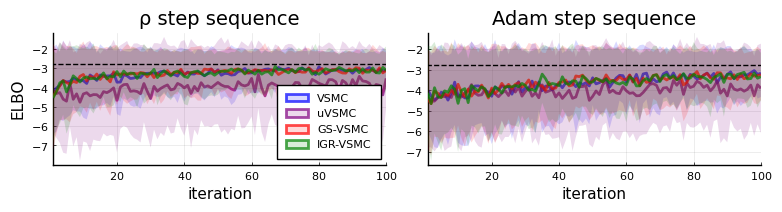

In [125]:
iters = 100
runs = 100
λ = 1.

function plot_gd_helper(obj, ∇obj, λ, iters, runs; step="rho")
    objs = zeros(runs,iters)
    for i in 1:runs
        λs, obs = gradient_descent(obj, ∇obj, [λ], iters=iters, step=step)
        objs[i,:] = obs
    end
    return mean(objs,dims=1)', var(objs,dims=1)'
end

pyplot(size=(770,200))

#λs_vsmc, objs_vsmc = gradient_descent(SLGSS_obj_vsmc, ∇SLGSS_obj_vsmc, [λ], iters=iters)
#λs_uvsmc, objs_uvsmc = gradient_descent(SLGSS_obj_uvsmc, ∇SLGSS_obj_uvsmc, [λ], iters=iters)
#λs_gs, objs_gs = gradient_descent(SLGSS_obj_gs, ∇SLGSS_obj_gs, [λ], iters=iters)
#λs_igr, objs_igr = gradient_descent(SLGSS_obj_igr, ∇SLGSS_obj_igr, [λ], iters=iters)

obj_mean_vsmc, obj_var_vsmc = plot_gd_helper(SLGSS_obj_vsmc, ∇SLGSS_obj_vsmc, λ, iters, runs)
obj_mean_uvsmc, obj_var_uvsmc = plot_gd_helper(SLGSS_obj_uvsmc, ∇SLGSS_obj_uvsmc, λ, iters, runs)
obj_mean_gs, obj_var_gs = plot_gd_helper(SLGSS_obj_gs, ∇SLGSS_obj_gs, λ, iters, runs)
obj_mean_igr, obj_var_igr = plot_gd_helper(SLGSS_obj_igr, ∇SLGSS_obj_igr, λ, iters, runs)

# println("λ*: ",λs[iters])
# println("Final VSMC bound: ", SLGSS_obj(λs[iters],verbose=true))

pelbo1 = plot(1:iters, obj_mean_vsmc, ribbon=sqrt.(obj_var_vsmc), label=VSMC,
    xlab="iteration", ylab="ELBO", title="ρ step sequence", xlim=(1,iters), legend=:bottomright,
    linecolor=VSMC_col, fillcolor=VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(1:iters, obj_mean_uvsmc, ribbon=sqrt.(obj_var_uvsmc), label=uVSMC,
    linecolor=uVSMC_col, fillcolor=uVSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(1:iters, obj_mean_gs, ribbon=sqrt.(obj_var_gs), label=GS_VSMC,
    linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(1:iters, obj_mean_igr, ribbon=sqrt.(obj_var_igr), label=IGR_VSMC,
    linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)

obj_mean_vsmc, obj_var_vsmc = plot_gd_helper(SLGSS_obj_vsmc, ∇SLGSS_obj_vsmc, λ, iters, runs, step="adam")
obj_mean_uvsmc, obj_var_uvsmc = plot_gd_helper(SLGSS_obj_uvsmc, ∇SLGSS_obj_uvsmc, λ, iters, runs, step="adam")
obj_mean_gs, obj_var_gs = plot_gd_helper(SLGSS_obj_gs, ∇SLGSS_obj_gs, λ, iters, runs, step="adam")
obj_mean_igr, obj_var_igr = plot_gd_helper(SLGSS_obj_igr, ∇SLGSS_obj_igr, λ, iters, runs, step="adam")

pelbo2 = plot(1:iters, obj_mean_vsmc, ribbon=sqrt.(obj_var_vsmc),
    xlab="iteration", title="Adam step sequence", xlim=(1,iters), legend=nothing,
    linecolor=VSMC_col, fillcolor=VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(1:iters, obj_mean_uvsmc, ribbon=sqrt.(obj_var_uvsmc),
    linecolor=uVSMC_col, fillcolor=uVSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(1:iters, obj_mean_gs, ribbon=sqrt.(obj_var_gs),
    linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(1:iters, obj_mean_igr, ribbon=sqrt.(obj_var_igr),
    linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)

plot(pelbo1, pelbo2)
if save_figures
    png("slgss_elbo")
end

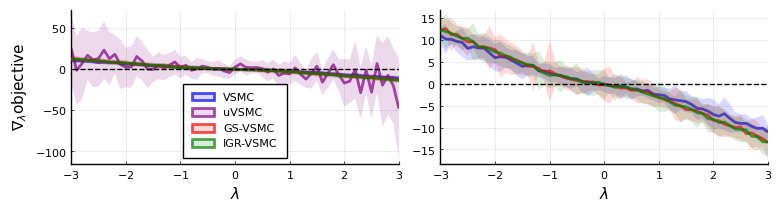

In [101]:
xs = -3:0.1:3
samples = 100

∇_means_vsmc, ∇_vars_vsmc = estimate_var(xs, ∇SLGSS_obj_vsmc, samples=samples)
∇_means_uvsmc, ∇_vars_uvsmc = estimate_var(xs, ∇SLGSS_obj_uvsmc, samples=samples)
∇_means_gs, ∇_vars_gs = estimate_var(xs, ∇SLGSS_obj_gs, samples=samples)
∇_means_igr, ∇_vars_igr = estimate_var(xs, ∇SLGSS_obj_igr, samples=samples)

pyplot(size=(770,200))
pvar1 = plot(xs, ∇_means_vsmc, ribbon=sqrt.(∇_vars_vsmc), label=VSMC,
    xlab=L"\lambda", ylab=L"\nabla_\lambda\mathrm{objective}", xlim=(min(xs...),max(xs...)), legend=:bottom,
    linecolor=VSMC_col, fillcolor=VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(xs, ∇_means_unbiased, ribbon=sqrt.(∇_vars_uvsmc), label=uVSMC,
    linecolor=uVSMC_col, fillcolor=uVSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(xs, ∇_means_gs, ribbon=sqrt.(∇_vars_gs), label=GS_VSMC,
    linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(xs, ∇_means_igr, ribbon=sqrt.(∇_vars_igr), label=IGR_VSMC,
    linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
hline!([0], linecolor=:black, linestyle=:dash, label=nothing)

pvar2 = plot(xs, ∇_means_vsmc, ribbon=∇_stds_vsmc,
    xlab=L"\lambda", xlim=(min(xs...),max(xs...)), legend=nothing,
    linecolor=VSMC_col, fillcolor=VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(xs, ∇_means_gs, ribbon=∇_stds_gs,
    linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
plot!(xs, ∇_means_igr, ribbon=∇_stds_igr,
    linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col, linewidth=2, fillalpha=0.15, lineopacity=0.7)
hline!([0], linecolor=:black, linestyle=:dash, label=nothing)

plot(pvar1,pvar2)
if save_figures
    png("grad_est_var")
end

# Linear Gaussian state space model

In [10]:
function LGSS_init_model_params(dimX, dimY, α, r)
    μ0 = zeros(dimX)
    Σ0 = Matrix{Float64}(I,dimX,dimX)
    
    A = zeros(dimX,dimX)
    for i in 1:dimX
        for j in 1:dimX
            A[i,j] = α^(abs(i-j)+1)
        end
    end
    
    Q = Matrix{Float64}(I,dimX,dimX)
    
    C = randn(dimY,dimX)
    
    R = r*Matrix{Float64}(I,dimY,dimY)
    
    return μ0, Σ0, A, Q, C, R
end

function LGSS_init_prop_params(T, dimX, scale)
    return [(scale*randn(dimX), # Bias
            1 .+ scale*randn(dimX), # Linear times A/μ0
            scale*randn(dimX)) # Log-var
            for t in 1:T]
end

function LGSS_generate_data(model_params, T)
    μ0, Σ0, A, Q, C, R = model_params
    dimX = size(μ0)[1]
    dimY = size(R)[1]
    
    x_true = zeros(T,dimX)
    y_true = zeros(T,dimY)
    
    for t in 1:T
        if t > 1
            x_dist = MvNormal(A*x_true[t-1,:],Q)
        else
            x_dist = MvNormal(μ0,Σ0)
        end
        x_true[t,:] = rand(x_dist,1)
        
        y_dist = MvNormal(C*x_true[t,:],R)
        y_true[t,:] = rand(y_dist,1)
    end
    return x_true, y_true
end

function LGSS_sim_prop(t, X_anc, y, prop_params, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    μt, lint, log_σ2t = prop_params[t]
    σt = sqrt.(exp.(log_σ2t))
    
    N, dimX = size(X_anc)
    
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = (μt + lint.*μ0)'
    end
    return μ .+ randn(N,dimX) .* σt'
end

function LGSS_log_prop(t,X,X_anc,y,prop_params,model_params)
    μ0, Σ0, A, Q, C, R = model_params
    μt, lint, log_σ2t = prop_params[t]
    σ2t = exp.(log_σ2t)
    dimX = length(σ2t)
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = μt + lint.*μ0
    end
    return log_normal(X,μ,Matrix{Float64}(I,dimX,dimX).*σ2t)#Matrix{Float64}(I,dimX,dimX) .* σ2t)
end

function LGSS_log_weights(t, X, X_anc, y, prop_params, model_params)
    return log_target(t,X,X_anc,y,model_params) - LGSS_log_prop(t,X,X_anc,y,prop_params,model_params)
end

function LGSS_flatten_params(prop_params, T, dimX)
    dimλ = 3*T*dimX
    flat_params = zeros(dimλ)
    k = 3*dimX
    for i in 1:T
        flat_params[(1+k*(i-1)):(k+k*(i-1))] .= (prop_params[i][1]...,prop_params[i][2]...,prop_params[i][3]...)
    end
    return flat_params, dimλ
end

function LGSS_unflatten_params(flat_params, T, dimX)
    k = 3*dimX
    return [(flat_params[(1+k*(i-1)):(dimX+k*(i-1))],
             flat_params[(1+dimX+k*(i-1)):(2*dimX+k*(i-1))],
             flat_params[(1+2*dimX+k*(i-1)):(k+k*(i-1))]) for i in 1:T]
end

LGSS_unflatten_params (generic function with 1 method)

True log-marginal likelihood: -48.9168193595918
ESS: 0.5952739593945648
Final VSMC bound: -220.10311953609315


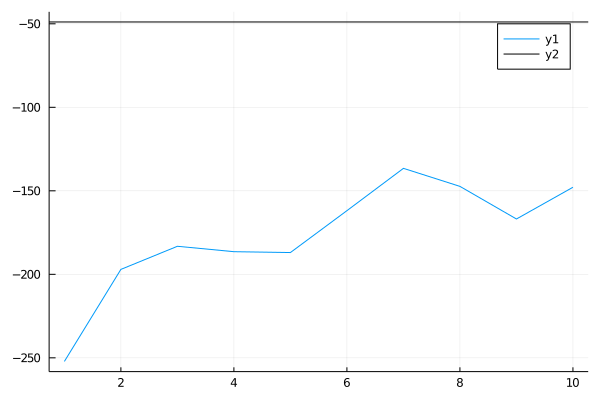

In [11]:
# Model hyperparameters
T = 10
dimX = 10
dimY = 3
α = 0.42
r = 1 #0.1

# Training parameters
param_scale = 0.5

N = 4

model_params = LGSS_init_model_params(dimX, dimY, α, r)

x_true, y_true = LGSS_generate_data(model_params, T)
# println("True x: ", x_true)
# println("True y: ", y_true)

log_marginal = log_marginal_likelihood(model_params, T, y_true, dimX)
println("True log-marginal likelihood: ", log_marginal)

prop_params = LGSS_init_prop_params(T, dimX, param_scale)

lgss_smc = SMC(dimX, dimY, T, N, LGSS_sim_prop, LGSS_log_weights)
flat_params, dimλ = LGSS_flatten_params(prop_params, T, dimX)

function LGSS_obj(flat_λ; verbose=false)
    λ = LGSS_unflatten_params(flat_λ, T, dimX)
    # return vsmc_lower_bound(λ, model_params, y_true, lgss_smc, verbose=verbose)
    # return vsmc_lower_bound(λ, model_params, y_true, lgss_smc, method="gumbelsoftmax", τ=0.05, verbose=verbose)
    return vsmc_lower_bound(λ, model_params, y_true, lgss_smc, method="invertgaussian", τ=0.05, verbose=verbose)
end
function ∇LGSS_obj(flat_λ)
    #grad_f = grad(LGSS_obj)
    #∇flat_λ = grad_f(flat_λ)
    
    grad_f = ForwardDiff.gradient(flat_λ->LGSS_obj(flat_λ),flat_λ)
    ∇flat_λ = grad_f
    
    #∇λ = ∇vsmc_lower_bound(λ,model_params,y_true,slgss_smc)
    return ∇flat_λ
end
iters = 10

flat_λs, vsmcb = gradient_descent(LGSS_obj, ∇LGSS_obj, flat_params, iters=iters)

println("Final VSMC bound: ", LGSS_obj(flat_λs[iters,:],verbose=true))
plot(1:iters, vsmcb)
hline!([log_marginal], linecolor=:black)